In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


In [2]:
# Here, we will load inception model to get the 128-dimensional vector and then we will load the pre-trained weights 
# for this model.
# This network uses 96x96 dimensional RGB images as its input. Specifically, 
# inputs a face image (or batch of  mm  face images) as a tensor of shape  (m,nC,nH,nW)=(m,3,96,96)(m,nC,nH,nW)=
# (m,3,96,96)
# It outputs a matrix of shape  (m,128)  that encodes each input face image into a 128-dimensional vector



In [3]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


In [4]:
# Now we will define function for triplet loss for anchor, positive image and negative image.
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    basic_loss = pos_dist-neg_dist+alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))
    
    return loss

In [5]:
# Now we will load the previously trained weights. Facenet model is trained by minimizing the triplet loss. It 
# requires lots of data and lots of computation. So, It will be easy for us to load the previously trained weights.
# Function load_weights is defined in fr_utils.py
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [7]:
def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

In [9]:
# face Verification
# We would create datasets of encoding for verification in a dictionary
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)


In [50]:
def verify(image_path, identity, database, model):
    # Compute the encoding for the image.
    encoding = img_to_encoding(image_path,model)
    
    # Compute distance with identity's image
    dist = np.linalg.norm(encoding-database[identity])
    
    if dist<0.75:
        print("It's " + str(identity) + ", welcome home!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    return dist, door_open

In [17]:

verify("images/camera_0.jpg", "younes", database, FRmodel)


It's younes, welcome home!


(0.6710074, True)

In [18]:
verify("images/camera_2.jpg", "kian", database, FRmodel)


It's not kian, please go away


(0.85800153, False)

In [19]:
# Face recognition
def who_is_it(image_path, database, model):
    encoding = img_to_encoding(image_path,model)
    min_dist = 100
    for (name, db_enc) in database.items():
        dist = np.linalg.norm(encoding-db_enc)
        if dist<min_dist:
            min_dist = dist
            identity = name
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [20]:
who_is_it("images/camera_0.jpg", database, FRmodel)

it's younes, the distance is 0.6710074


(0.6710074, 'younes')

In [22]:
image_path='images/danielle.png'
img1 = cv2.imread(image_path, 1)
img1.shape

(96, 96, 3)

In [41]:
image_path='images/Raman.jpg'
from keras.preprocessing import image
img = image.load_img(image_path, target_size=(96,96,3))
x = image.img_to_array(img)
img.save('Raman1.jpg')

In [39]:
database["raman"]=img_to_encoding('Raman1.jpg', FRmodel)

In [40]:
who_is_it("Raman1.jpg", database, FRmodel)

it's raman, the distance is 0.0


(0.0, 'raman')

In [42]:
image_path='images/Raman2.jpg'
from keras.preprocessing import image
img = image.load_img(image_path, target_size=(96,96,3))
x = image.img_to_array(img)
img.save('images/Raman3.jpg')

In [44]:

verify("images/Raman3.jpg", "raman", database, FRmodel)

It's raman, welcome home!


(0.6658608, True)

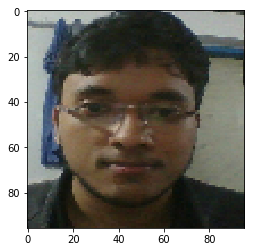

In [47]:
image_path='images/raman4.jpg'
from keras.preprocessing import image
img = image.load_img(image_path, target_size=(96,96,3))
x = np.array(img)
plt.imshow(x)
img.save('images/Raman5.jpg')

In [51]:
verify("images/Raman5.jpg", "raman", database, FRmodel)

It's raman, welcome home!


(0.7272626, True)